<a href="https://colab.research.google.com/github/sarthakkaushik/Diploma-Program-in-ML-and-AI/blob/main/TimeSeriesForecasting_LSTMs_Using_MWA%2C_Uni_LSTM%2C_Multi_SS_MS_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Source/Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

## Dataset

In [24]:
#imports

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [25]:
# get data
# data source: Max Plank Institute, https://www.bgc-jena.mpg.de/wetter/

zip_path = tf.keras.utils.get_file( # 
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

print(zip_path)

csv_path, _ = os.path.splitext(zip_path) # https://docs.python.org/3/library/os.path.html
print(csv_path)

/root/.keras/datasets/jena_climate_2009_2016.csv.zip
/root/.keras/datasets/jena_climate_2009_2016.csv


In [26]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [27]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Observations:
1. One reading every 10 mins
2. 1 day = 6*24 = 144 readings
3. 5 days = 144*5 = 720 readings


**Forecasting task:**  Predict temperature (in deg C) in the future.




In [28]:
# univariate data: Temp vs Time

uni_data_df = df['T (degC)']
uni_data_df.index = df['Date Time']
uni_data_df.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

In [29]:
uni_data_df.shape

(420551,)

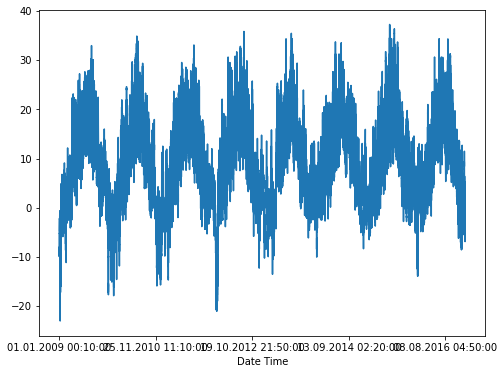

In [30]:
uni_data_df.plot()

In [31]:
uni_data = uni_data_df.values # numpy ndarray from pandas

In [32]:
uni_data[0]

-8.02

In [33]:
TRAIN_SPLIT = 300000 # First 300000 obs will be used as train data and rest as test data.
# 300,000 => ~2100 days worth of training data


tf.random.set_seed(13) # random seed 

# Normalize data: mean centering and variance-scaling.
# NOTE: use only train data to normalize all of the data. otherwise, leakage-issue 
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
print(type(uni_data))

<class 'numpy.ndarray'>


## Moving window average

### Pose a simple problem: 
Given last 'k' values of temp-observations (only one feature <=> univariate), predict the next observation

### MWA: 
Average the previous k values to predict the next value.

In [34]:
np.reshape(uni_data[range(0,20)],(20,1))

array([[-1.99766294],
       [-2.04281897],
       [-2.05439744],
       [-2.0312405 ],
       [-2.02660912],
       [-2.00113649],
       [-1.95134907],
       [-1.95134907],
       [-1.98492663],
       [-2.04513467],
       [-2.08334362],
       [-2.09723778],
       [-2.09376424],
       [-2.09144854],
       [-2.07176515],
       [-2.07176515],
       [-2.07639653],
       [-2.08913285],
       [-2.09260639],
       [-2.10418486]])

In [35]:
uni_data[range(0,20)]

array([-1.99766294, -2.04281897, -2.05439744, -2.0312405 , -2.02660912,
       -2.00113649, -1.95134907, -1.95134907, -1.98492663, -2.04513467,
       -2.08334362, -2.09723778, -2.09376424, -2.09144854, -2.07176515,
       -2.07176515, -2.07639653, -2.08913285, -2.09260639, -2.10418486])

In [36]:
# This function creates the data we need for the above problem
# dataset: numpy ndarray
# start_index:
# end_index:
# history_size: k => take k values at a time
# target_size: 0 => next value in the time-series
# Output: data: (n,k) and labels (n,1)

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # print(indices)
    # print(np.reshape(dataset[indices], (history_size, 1)))
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


# use the above function to create the datasets.
univariate_past_history = 20 # How much past observation to be used to predict at point t 
univariate_future_target = 0 # future time you want to predict at time =0 ~ current t , time=10~ t+10, time=20 ~t+20

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)



(299980, 20, 1)
(299980,)
(120531, 20, 1)
(120531,)


In [37]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [38]:
#utility function
def create_time_steps(length):
  return list(range(-length, 0))

print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

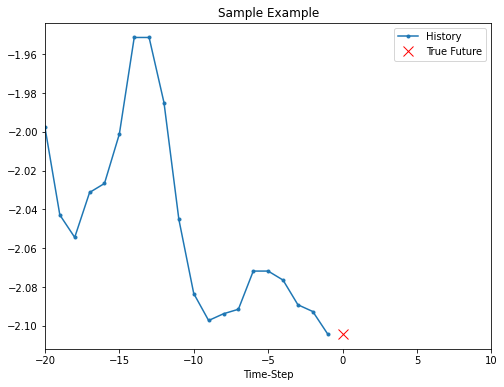

In [39]:
# Plotting function

# plot_data: contains labels as list
# delta: 0 => next time step given last "k" steps.
# title: plot title

# Usage: show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

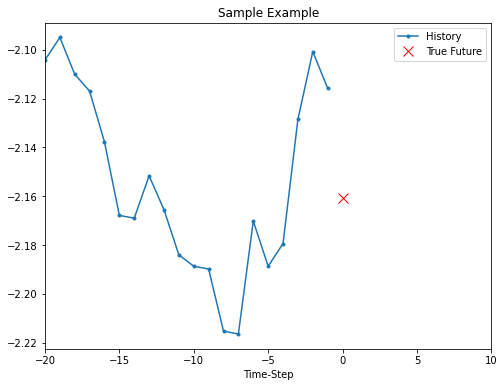

In [40]:
i=20
show_plot([x_train_uni[i], y_train_uni[i]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

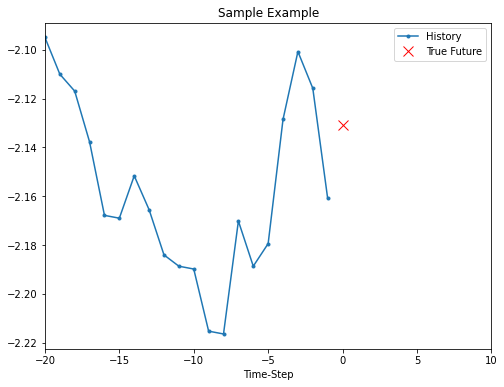

In [41]:
i=21
show_plot([x_train_uni[i], y_train_uni[i]], 0, 'Sample Example')

In [42]:
def mwa(history):
  return np.mean(history)

In [43]:
print(list(enumerate([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])])))

[(0, array([[-2.09492208],
       [-2.10997409],
       [-2.11692118],
       [-2.13776242],
       [-2.16786644],
       [-2.16902429],
       [-2.15165658],
       [-2.16555075],
       [-2.1840763 ],
       [-2.18870768],
       [-2.18986553],
       [-2.21533816],
       [-2.21649601],
       [-2.17018213],
       [-2.18870768],
       [-2.17944491],
       [-2.12849964],
       [-2.10071132],
       [-2.11576333],
       [-2.16091936]])), (1, -2.130815338672388), (2, -2.1576194945707474)]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

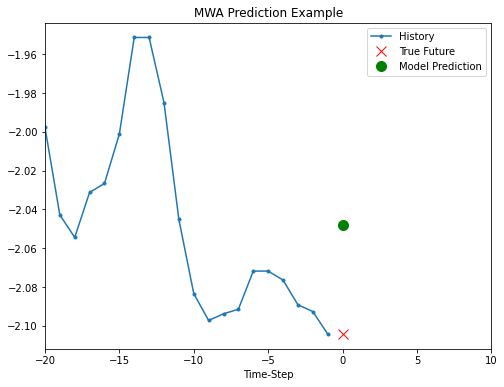

In [44]:
i=0
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

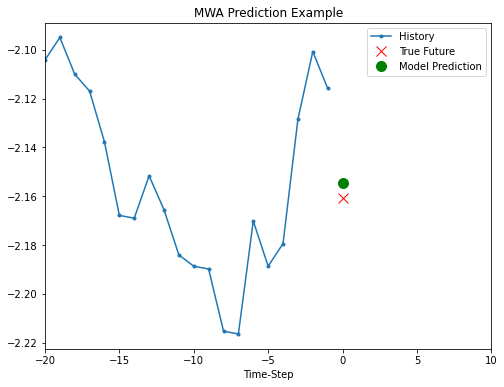

In [45]:
i=20
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

## Univariate time-series forecasting

-  Features from the history: only temperature => univariate

- Problem definition: Given last "k=20" values of temp, predict the next temp value.

In [46]:
# TF Dataset preperation
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# .cache() improve you performance when you need to move each bacth of data into your main meomery(gpu etc). Chacheing is good strategy to improve memory performance.
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni)) # Converting our datasaet into tesnorflow dataset
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)
print(val_univariate)


<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>


In [47]:
# MODEL:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

# Why not GRUs?
# https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU

In [48]:
# Train and evaluate
STEPS_PER_EPOCH = 200
EPOCHS = 30

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 6s 6ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/30
200/200 [==============================] - 1s 5ms/step - loss: 0.1118 - val_loss: 0.0360
Epoch 3/30
200/200 [==============================] - 1s 4ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/30
200/200 [==============================] - 1s 5ms/step - loss: 0.0444 - val_loss: 0.0258
Epoch 5/30
200/200 [==============================] - 1s 4ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/30
200/200 [==============================] - 1s 4ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/30
200/200 [==============================] - 1s 4ms/step - loss: 0.0287 - val_loss: 0.0207
Epoch 8/30
200/200 [==============================] - 1s 4ms/step - loss: 0.0263 - val_loss: 0.0199
Epoch 9/30
200/200 [==============================] - 1s 4ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/30
200/200 [==============================] - 1s 4ms/step - loss: 0.0227 - val_loss: 0.0174

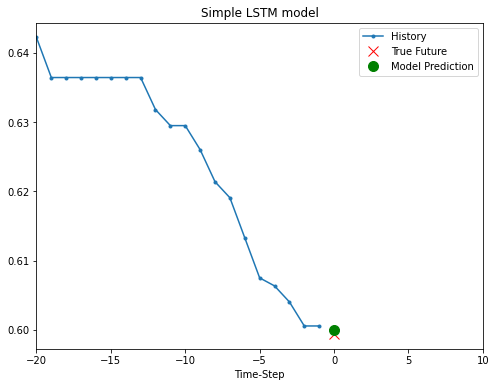

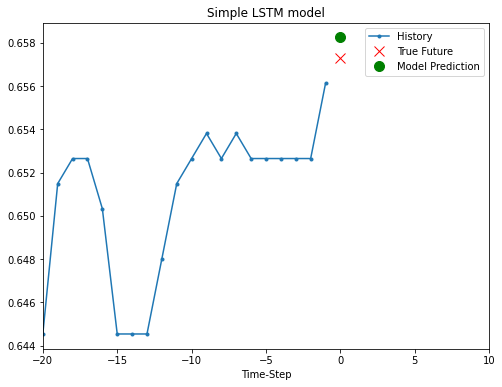

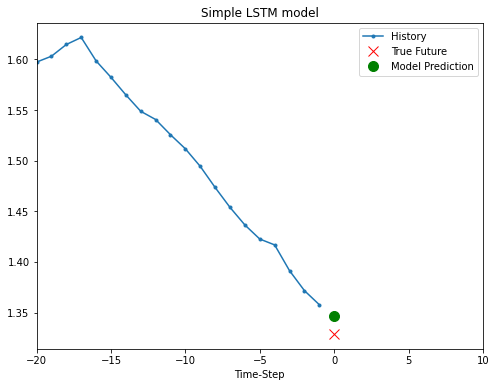

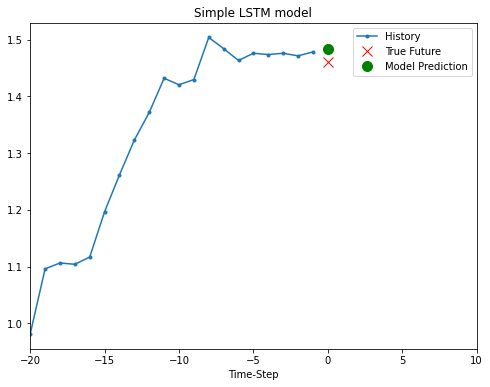

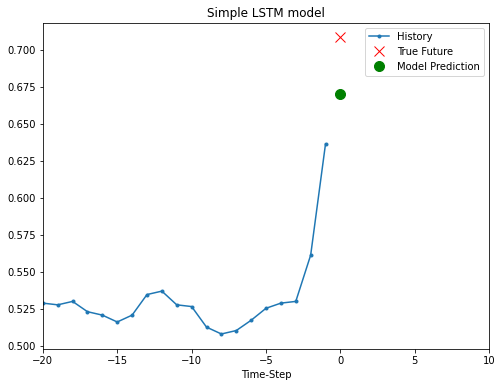

In [49]:

for x, y in val_univariate.take(5): # take 5 random inputs from validation data
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Multi-variate & single-step forecasting

- Problem definition: Given three features (p, T, rho) at each time stamp in the past, predict the temperature at a single time-stamp in the future.

In [50]:
# Features
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4256f7aad0>,
      dtype=object)

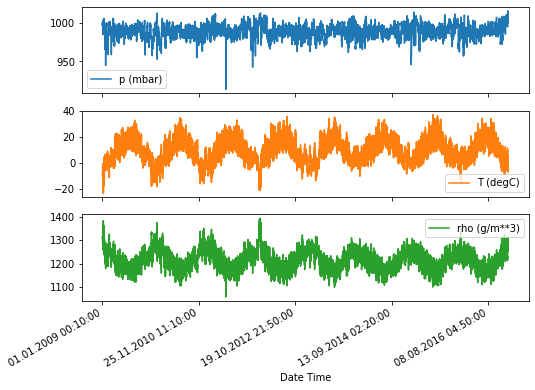

In [51]:
features.plot(subplots=True)

In [52]:
# Standardize data

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [53]:
# Same as univariate_data above.

# New params:
# step: instead of taking data for each 10min, do you want to generate data once evrey 6 steps (60min)
# single_step: lables from single timestamp or multiple timesteps


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [54]:
# Generate data
past_history = 720 # 720*10 mins 
future_target = 72 # 72*10 mins
STEP = 6 # one obs every 6X10min = 60 min => 1 hr

# past history: 7200 mins => 120 hrs, sampling at one sample evry hours 
# future_target: 720 mins = > 12 hrs in the future, not next hour

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)

(299280, 120, 3)
(299280,)


In [55]:
#TF dataset

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<RepeatDataset shapes: ((None, 120, 3), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 120, 3), (None,)), types: (tf.float64, tf.float64)>


In [56]:
# Model
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/30
200/200 [==============================] - 4s 11ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2624 - val_loss: 0.2425
Epoch 3/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2614 - val_loss: 0.2468
Epoch 4/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2566 - val_loss: 0.2451
Epoch 5/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2264 - val_loss: 0.2350
Epoch 6/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2414 - val_loss: 0.2691
Epoch 7/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2405 - val_loss: 0.2555
Epoch 8/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2397 - val_loss: 0.2398
Epoch 9/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2447 - val_loss: 0.2466
Epoch 10/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2383 - val_loss: 0.244

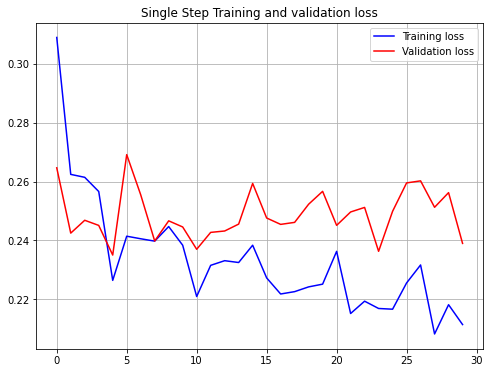

In [57]:
# Plot train and validation loss over epochs

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

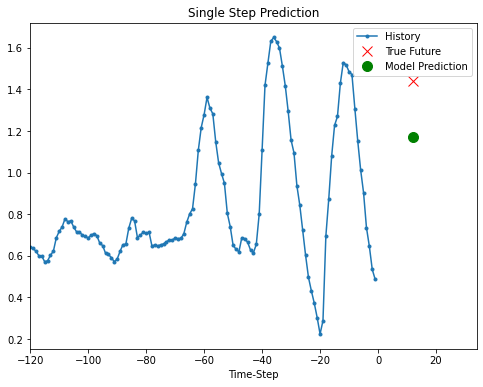

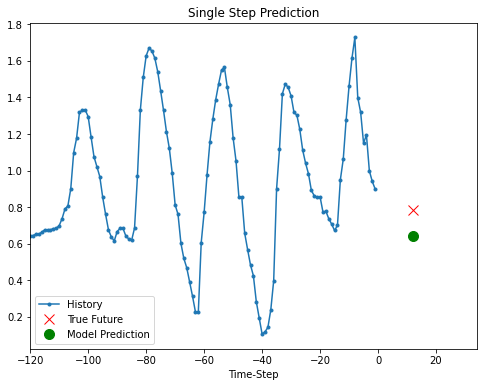

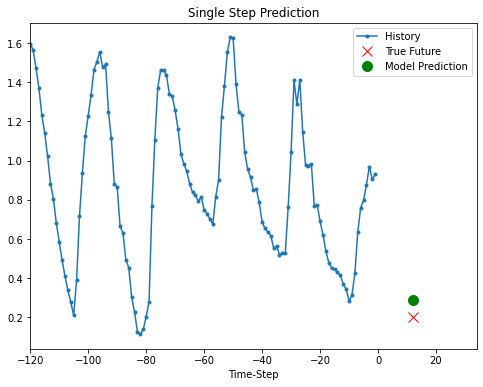

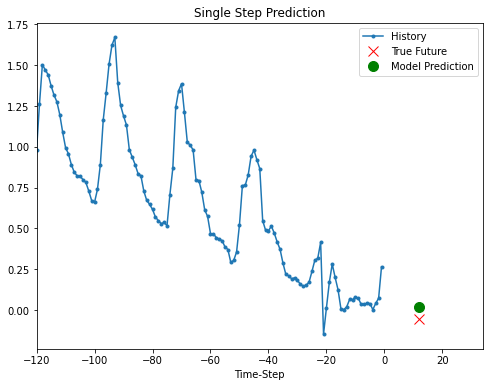

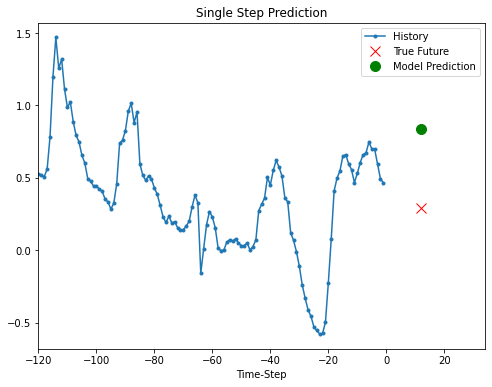

In [58]:
# plot time series and predicted values

for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()


## Multi-variate & multi-step forecasting
- Generate multiple future values of temperature

In [59]:
# single_step=FALSE default value

future_target = 72 # 72 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(299280, 120, 3)
(299280, 72)
(119759, 120, 3)
(119759, 72)


In [60]:
dataset = tf.data.Dataset.from_tensor_slices(np.array[1, 2, 3],np.array[5,6,7])
for i,element in enumerate(dataset):
  print(i,"+",element)

TypeError: ignored

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
for i,element in enumerate(dataset):
  if i<1:
    print(i,"+",element)
  else:
    break

In [61]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

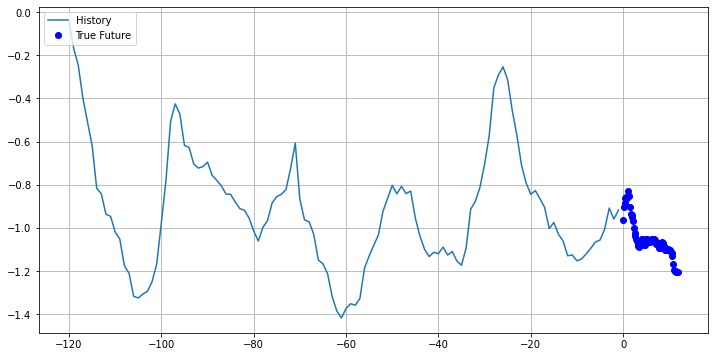

In [62]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [63]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# multi_step_model.add(tf.keras.layers.LSTM(8, activation='relu'))
# multi_step_model.add(tf.keras.layers.LSTM(4, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/30
200/200 [==============================] - 37s 175ms/step - loss: 0.4955 - val_loss: 0.3060
Epoch 2/30
200/200 [==============================] - 34s 171ms/step - loss: 0.3471 - val_loss: 0.2871
Epoch 3/30
200/200 [==============================] - 34s 169ms/step - loss: 0.3278 - val_loss: 0.2495
Epoch 4/30
200/200 [==============================] - 34s 168ms/step - loss: 0.2403 - val_loss: 0.2065
Epoch 5/30
200/200 [==============================] - 33s 167ms/step - loss: 0.1960 - val_loss: 0.1971
Epoch 6/30
200/200 [==============================] - 34s 168ms/step - loss: 0.2052 - val_loss: 0.2013
Epoch 7/30
200/200 [==============================] - 33s 167ms/step - loss: 0.1968 - val_loss: 0.2010
Epoch 8/30
200/200 [==============================] - 33s 167ms/step - loss: 0.1948 - val_loss: 0.1961
Epoch 9/30
200/200 [==============================] - 33s 166ms/step - loss: 0.1971 - val_loss: 0.1846
Epoch 10/30
200/200 [==============================] - 34s 168ms/step - l

In [64]:

def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(Y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [65]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu',return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(8, activation='relu'))
# multi_step_model.add(tf.keras.layers.LSTM(4, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/30
200/200 [==============================] - 68s 325ms/step - loss: 28.7072 - val_loss: 140.0288
Epoch 2/30
200/200 [==============================] - 64s 321ms/step - loss: 319.2019 - val_loss: 0.2951
Epoch 3/30
200/200 [==============================] - 64s 322ms/step - loss: 0.3636 - val_loss: 0.3068
Epoch 4/30
200/200 [==============================] - 64s 322ms/step - loss: 393.7257 - val_loss: 0.3270
Epoch 5/30
200/200 [==============================] - 65s 324ms/step - loss: 0.2958 - val_loss: 0.2650
Epoch 6/30
200/200 [==============================] - 65s 323ms/step - loss: 0.2806 - val_loss: 0.2634
Epoch 7/30
200/200 [==============================] - 65s 323ms/step - loss: 0.2542 - val_loss: 0.2792
Epoch 8/30
200/200 [==============================] - 65s 323ms/step - loss: 0.2455 - val_loss: 0.2533
Epoch 9/30
200/200 [==============================] - 64s 322ms/step - loss: 0.2496 - val_loss: 0.2273
Epoch 10/30
200/200 [==============================] - 65s 323ms/s

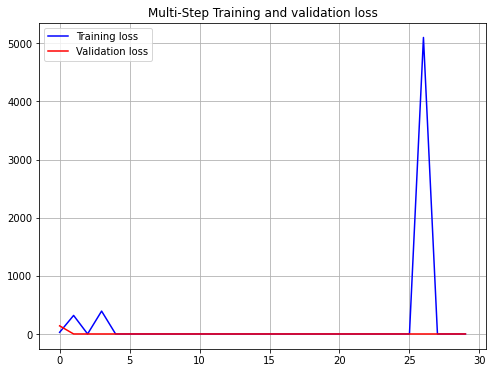

In [66]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


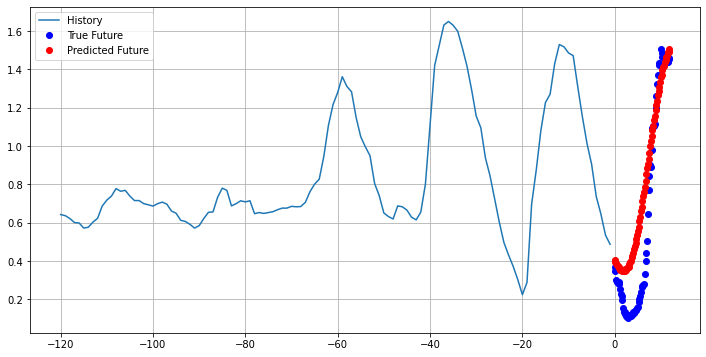

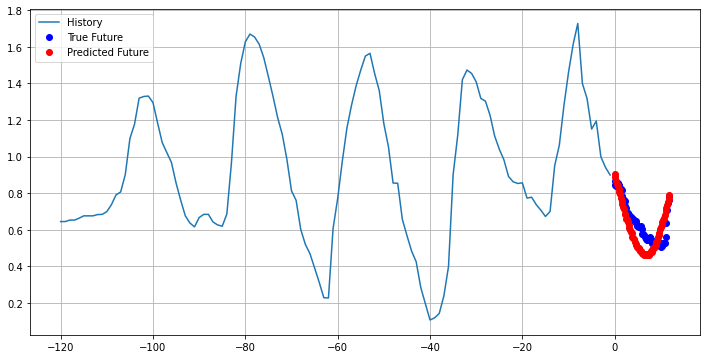

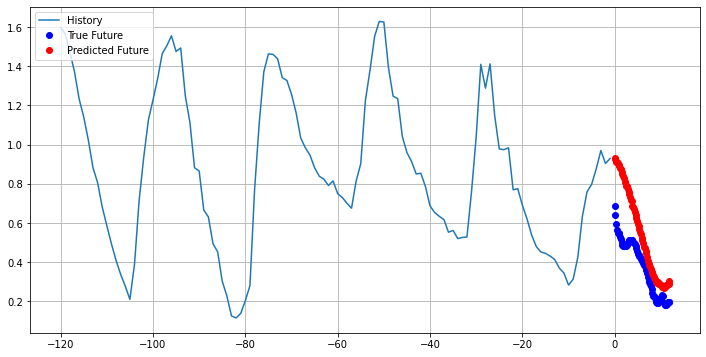

In [67]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# Optimizing LSTM using Keras Tuner

In [68]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 5.0 MB/s 


In [69]:
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [70]:
#Whats is ‘hp’?
#Hp is an object that we pass to the model-building function, that allows us to define the space search of the hyperparameters.

def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=x_train_multi.shape[-2:]))
    for i in range(hp.Int('n_layers', 1, 4)): # no. of layes usinng to search keras tuner
        model.add(tf.keras.layers.LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True)) 
    model.add(tf.keras.layers.LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(tf.keras.layers.Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(tf.keras.layers.Dense(72, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0))
    return model

In [71]:
#Creating the Tuner Object 
tuner= RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=3,
        executions_per_trial=1,
        directory='project',
        project_name='LSTM Time Series with Keras Tuner'
        )

In [72]:
# #we have created the tuner object, we can use the method search to find the best model.
# tuner.search(
#         x=train_data_multi,
#         # y=Y_train,
#         epochs=20,
#         batch_size=128,
#         # validation_data=(X_test,Y_test),
#         validation_data=val_data_multi,
#         validation_steps=50)

In [73]:
tuner.search(
        x=x_train_multi,
        y=y_train_multi,
        epochs=20,
        batch_size=128,
        validation_data=(x_val_multi,y_val_multi),
        # validation_data=val_data_multi,
        validation_steps=50)

Trial 3 Complete [00h 49m 20s]
val_loss: 0.2421913594007492

Best val_loss So Far: 0.23073899745941162
Total elapsed time: 03h 00m 20s
INFO:tensorflow:Oracle triggered exit


In [74]:
best_model = tuner.get_best_models(num_models=1)[0]

In [75]:
tuner.results_summary()

Results summary
Results in project/LSTM Time Series with Keras Tuner
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_unit: 96
n_layers: 2
lstm_0_units: 480
layer_2_neurons: 480
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
lstm_1_units: 32
Score: 0.23073899745941162
Trial summary
Hyperparameters:
input_unit: 192
n_layers: 3
lstm_0_units: 480
layer_2_neurons: 384
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
lstm_1_units: 192
lstm_2_units: 32
Score: 0.23709994554519653
Trial summary
Hyperparameters:
input_unit: 320
n_layers: 1
lstm_0_units: 192
layer_2_neurons: 448
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
lstm_1_units: 416
lstm_2_units: 64
Score: 0.2421913594007492


In [76]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layer_2_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
lstm_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
lstm_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
